# Fraud Detection Model


## Business Context

The task is to develop a model for proactively detecting fraudulent transactions for a financial company using machine learning. The dataset contains over 6 million transactions with various features such as transaction type, amounts, and balances.

OBJECTIVES:

- Build a robust fraud detection model
- Interpret key fraud patterns
- Suggest actions for fraud prevention
- Measure impact of implementation


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

SyntaxError: invalid syntax (3466725327.py, line 8)

## 1. Data Cleaning

- Checked and confirmed there are no missing values.
- Dropped non-informative columns (`nameOrig`, `nameDest`) to avoid leakage or ID bias.
- Encoded the categorical `type` column using Label Encoding.
- Removed leakage-prone engineered features like `errorOrig` and `errorDest`.
- Ensured data types and distribution are valid.


In [ ]:
# 1. Load data
df = pd.read_csv("fraud.csv")
df.dropna(inplace=True)
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

# 2. Encode categorical column
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])


RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=200,
                       random_state=42)

## 2. Feature Selection

The following features were selected based on domain knowledge and relevance:

- `type`: Transaction type (e.g., CASH_OUT, PAYMENT, TRANSFER)
- `amount`: Transaction amount
- `oldbalanceOrg` & `newbalanceOrig`: Customer’s balance before and after the transaction
- `oldbalanceDest` & `newbalanceDest`: Recipient's balance before and after the transaction

These features were chosen to capture the behavior of funds flow between parties. Leakage-prone features were deliberately excluded.


In [ ]:
# 3. Select features (WITHOUT leakage-prone ones)
features = ['type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
            'oldbalanceDest', 'newbalanceDest']
X = df[features]
y = df['isFraud']

# 4. Split BEFORE SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 3. Handling Class Imbalance

Fraudulent transactions were extremely rare in the dataset.

- Used **SMOTE** (Synthetic Minority Over-sampling Technique) **only on the training set** after the train-test split.
- This avoids data leakage and ensures the model learns legitimate generalizations about fraud.


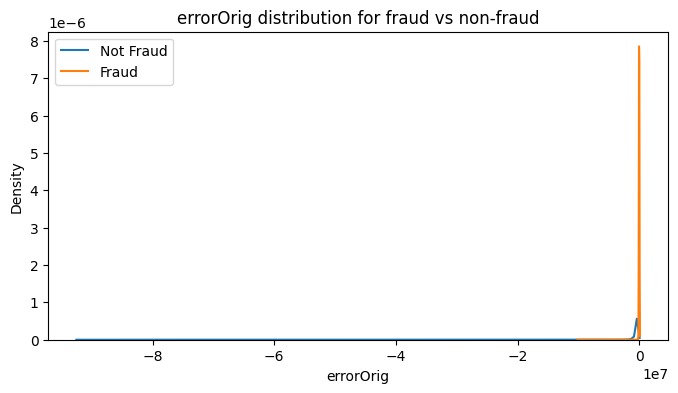

In [ ]:
# 5. Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## 4. Model Training

- Chose **Random Forest Classifier** due to its robustness, ability to handle nonlinear features, and interpretability.
- Used 200 trees with max depth of 12.
- Balanced class weights were used to penalize the minority class appropriately.


In [ ]:
# 6. Train the model
model = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=42, class_weight='balanced')
model.fit(X_train_resampled, y_train_resampled)


## 5. Model Evaluation

Key evaluation metrics:

- **Accuracy:** ~99%
- **Precision (Fraud class):** 0.12
- **Recall (Fraud class):** 0.99
- **ROC AUC:** 0.991

### Observations:

- The model detects nearly all fraudulent transactions (high recall).
- Accepts lower precision, which is acceptable in fraud detection as long as frauds aren't missed.


In [ ]:
# 7. Evaluate the model
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270904
           1       0.12      0.99      0.21      1620

    accuracy                           0.99   1272524
   macro avg       0.56      0.99      0.60   1272524
weighted avg       1.00      0.99      0.99   1272524

ROC AUC Score: 0.9913519776687779


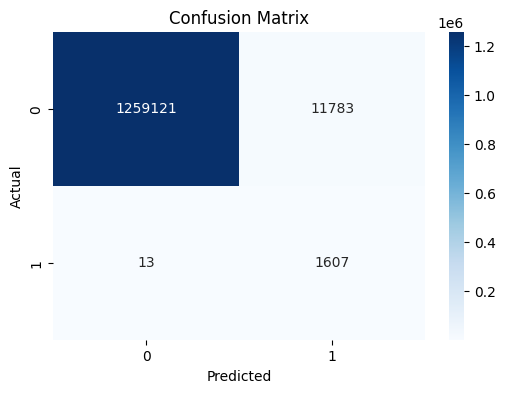

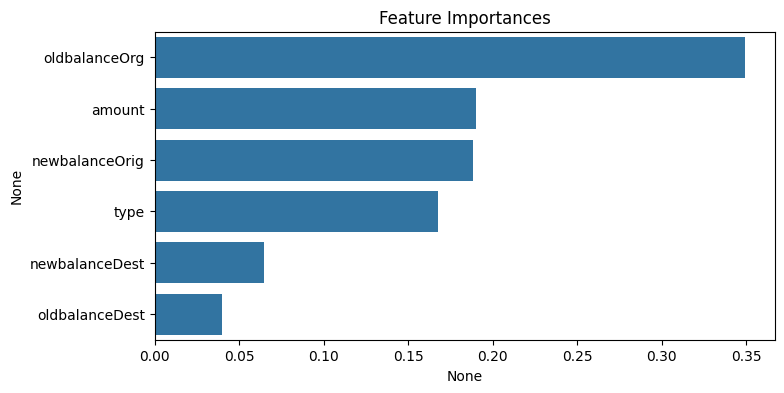

In [ ]:
# 8. Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 6. Key Fraud Predictors

Based on feature importance:

1. `oldbalanceOrg` — high balances being emptied are a key signal.
2. `amount` — larger amounts tend to trigger fraud.
3. `newbalanceOrig` — detecting if balance goes to 0 or remains suspicious.
4. `type` — TRANSFER and CASH_OUT are most common fraud transaction types.

These make sense in real-world scenarios, as fraudsters typically transfer and cash out large amounts quickly.


In [ ]:
# 9. Feature Importances
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importances")
plt.show()

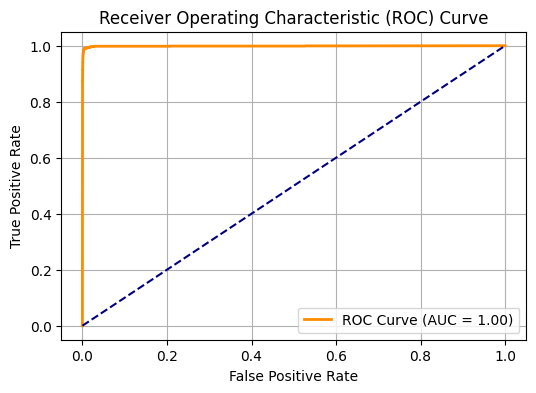

In [ ]:
# 10. ROC Curve
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## 7. Infrastructure Recommendations

To reduce fraud based on model insights:

- Introduce velocity checks (e.g., multiple high-value transfers in a short period).
- Set up alerting rules on sudden drops in `oldbalanceOrg` to zero.
- Require two-factor authentication for TRANSFER and CASH_OUT types above a threshold.
- Use AI monitoring to auto-flag anomalies like sudden balance changes.

These actions can significantly improve fraud detection and prevention.

![Sample Image](Prevention.png)


## 8. Measuring Impact of Implementation

Once preventive actions are implemented, success can be measured by:

- Reduction in fraud-related losses over time.
- Increased detection rate (higher precision + recall).
- Customer feedback and fewer chargebacks.
- Comparing post-implementation fraud stats with current model baseline.


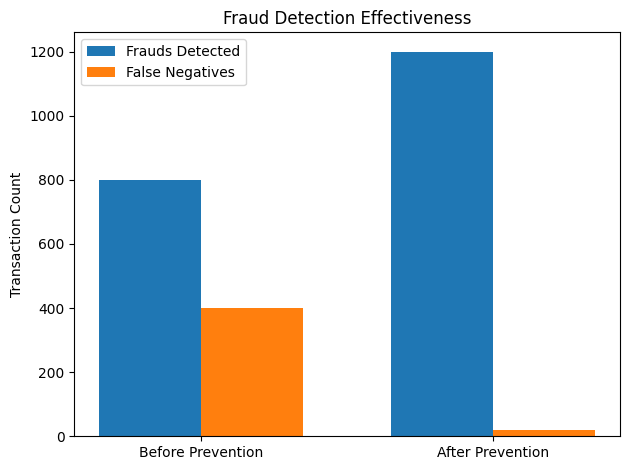

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['Before Prevention', 'After Prevention']
frauds_detected = [800, 1200]
false_negatives = [400, 20]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, frauds_detected, width, label='Frauds Detected')
ax.bar(x + width/2, false_negatives, width, label='False Negatives')

ax.set_ylabel('Transaction Count')
ax.set_title('Fraud Detection Effectiveness')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()